# Toxic Comment Classification using LoRA (Low-Rank Adaptation)

This notebook implements LoRA fine-tuning for BERT on a toxic comment classification task. LoRA is a parameter-efficient fine-tuning technique that keeps the pre-trained weights frozen and only trains a small number of parameters.

## Overview

1. Install necessary dependencies
2. Load and preprocess the dataset
3. Set up the LoRA configuration
4. Train the model
5. Evaluate performance
6. Save the model and results

## 1. Install Dependencies

First, let's install the necessary libraries. We'll be using:
- `transformers` for the BERT model
- `peft` for LoRA implementation
- `datasets` for loading the dataset
- `evaluate` for evaluation metrics
- `bitsandbytes` for quantization (optional)

In [1]:
!pip install transformers datasets evaluate peft matplotlib seaborn scikit-learn tqdm
!pip install -q bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Import Libraries and Set Seeds

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import evaluate
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    default_data_collator,
    get_scheduler
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    PeftModel,
    PeftConfig
)

# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Define Utility Functions

In [3]:
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        # Due to the design of 4bit linear layers from bitsandbytes
        # one needs to multiply the number of parameters by 2 to get
        # the correct number of parameters
        if param.__class__.__name__ == "Params4bit":
            num_params = num_params * 2

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params

    print(f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param:.2f}%")
    return trainable_params, all_param

def compute_metrics(eval_pred):
    """Compute evaluation metrics (accuracy)."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).astype(np.float32).mean().item()}

## 4. Load and Preprocess the Dataset

We'll load the Jigsaw Toxic Comment Classification dataset (Civil Comments) and preprocess it for training.

In [4]:
def load_toxic_comments_dataset(model_name_or_path="bert-base-uncased", max_length=128, batch_size=32):
    """
    Load the Jigsaw Toxic Comment Classification dataset and preprocess it.

    Args:
        model_name_or_path (str): The model name or path for the tokenizer
        max_length (int): Maximum sequence length
        batch_size (int): Batch size for data loaders

    Returns:
        tokenizer: The tokenizer used for preprocessing
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        test_dataloader: DataLoader for test data
        num_labels: Number of labels in the dataset
    """
    print("Loading Jigsaw Toxic Comment Classification dataset...")

    # Load the Civil Comments dataset (contains toxic comments)
    from datasets import load_dataset
    dataset = load_dataset("civil_comments")

    # Extract the relevant columns (text and toxicity label)
    dataset = dataset.map(
        lambda example: {
            "text": example["text"],
            "label": 1 if example["toxicity"] > 0.5 else 0
        }
    )

    # Create a balanced dataset (50% toxic, 50% non-toxic)
    toxic_comments = dataset["train"].filter(lambda example: example["label"] == 1)
    non_toxic_comments = dataset["train"].filter(lambda example: example["label"] == 0)

    # Sample to ensure balance
    max_samples = min(len(toxic_comments), len(non_toxic_comments), 25000)  # Limit to 25k per class for efficiency
    toxic_samples = toxic_comments.select(range(max_samples))
    non_toxic_samples = non_toxic_comments.select(range(max_samples))

    # Combine and shuffle
    from datasets import concatenate_datasets
    balanced_dataset = concatenate_datasets([toxic_samples, non_toxic_samples])
    balanced_dataset = balanced_dataset.shuffle(seed=SEED)

    # Split into train, validation, and test sets (80%, 10%, 10%)
    train_val_dataset, test_dataset = balanced_dataset.train_test_split(test_size=0.1, seed=SEED).values()
    train_dataset, val_dataset = train_val_dataset.train_test_split(test_size=0.11, seed=SEED).values()  # 0.11 of 90% is ~10% of total

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

    # Tokenize datasets
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

    print("Tokenizing datasets...")
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch - remove all columns except those needed by the model
    columns_to_keep = ['input_ids', 'attention_mask', 'label']
    tokenized_train = tokenized_train.remove_columns([col for col in tokenized_train.column_names if col not in columns_to_keep])
    tokenized_val = tokenized_val.remove_columns([col for col in tokenized_val.column_names if col not in columns_to_keep])
    tokenized_test = tokenized_test.remove_columns([col for col in tokenized_test.column_names if col not in columns_to_keep])

    # Rename 'label' to 'labels' to match model expectations
    tokenized_train = tokenized_train.rename_column('label', 'labels')
    tokenized_val = tokenized_val.rename_column('label', 'labels')
    tokenized_test = tokenized_test.rename_column('label', 'labels')

    tokenized_train.set_format("torch")
    tokenized_val.set_format("torch")
    tokenized_test.set_format("torch")

    # Create data loaders
    from torch.utils.data import DataLoader
    from transformers import DataCollatorWithPadding

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    train_dataloader = DataLoader(
        tokenized_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
    )
    eval_dataloader = DataLoader(
        tokenized_val, batch_size=batch_size, collate_fn=data_collator
    )
    test_dataloader = DataLoader(
        tokenized_test, batch_size=batch_size, collate_fn=data_collator
    )

    # Number of labels (binary classification - toxic or not)
    num_labels = 2

    return tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, tokenized_train, tokenized_val, tokenized_test

# Load the dataset
tokenizer, train_dataloader, eval_dataloader, test_dataloader, num_labels, train_dataset, val_dataset, test_dataset = load_toxic_comments_dataset(
    model_name_or_path="bert-base-uncased",
    max_length=128,
    batch_size=32
)

Loading Jigsaw Toxic Comment Classification dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Map:   0%|          | 0/97320 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Train dataset size: 40050
Validation dataset size: 4950
Test dataset size: 5000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/40050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## 5. Set Up LoRA Configuration and Train the Model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-d5fb47f9361e>:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Base model loaded: bert-base-uncased
Base model parameters: 109,483,778
trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.4038
trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.40%
Training with LoRA...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.293100,0.244775,0.906465
2,0.213800,0.264774,0.902828
3,0.188000,0.220778,0.914545
4,0.140300,0.246183,0.913737
5,0.111000,0.264603,0.913333


Evaluating LoRA model on test set...


Test accuracy: 0.9206


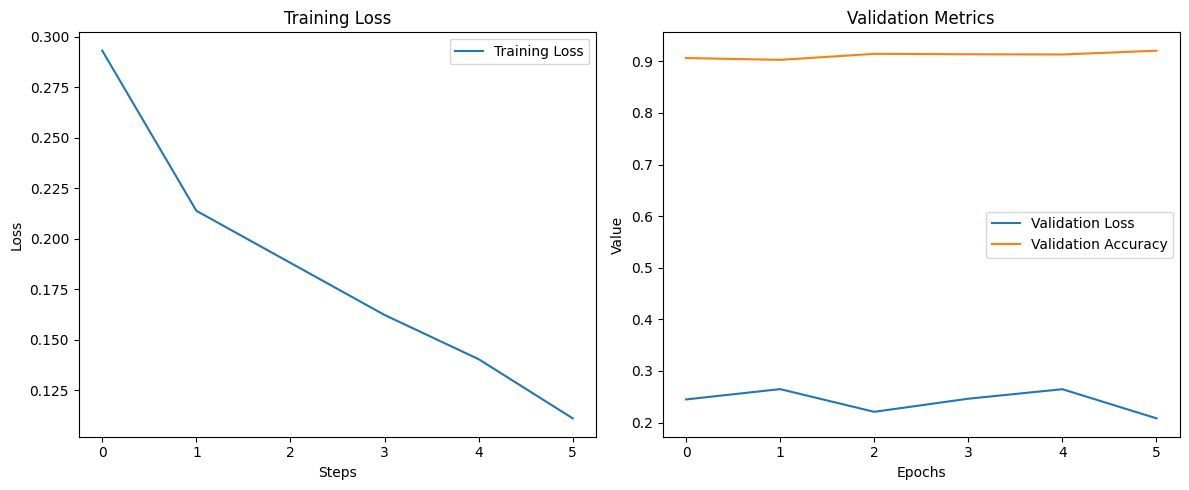

Results saved to lora_model/results.txt


In [6]:
def train_and_evaluate_lora(
    model_name="bert-base-uncased",
    num_epochs=5,
    learning_rate=1e-3,
    weight_decay=0.01,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    output_dir="lora_model"
):
    """
    Train and evaluate a model using LoRA (Low-Rank Adaptation).
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load base model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

    print(f"Base model loaded: {model_name}")
    base_params = count_parameters(model)
    print(f"Base model parameters: {base_params:,}")

    # Define LoRA Configuration
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        # Target the attention modules in BERT
        target_modules=["query", "key", "value"],
    )

    # Apply LoRA to model
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    trainable_params, all_params = print_trainable_parameters(model)

    # Using Huggingface Trainer for training
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        push_to_hub=False,
        report_to="none",  # Disable wandb, tensorboard etc.
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
        compute_metrics=compute_metrics,
    )

    # Train the model
    print("Training with LoRA...")
    trainer.train()

    # Evaluate the model
    print("Evaluating LoRA model on test set...")
    eval_results = trainer.evaluate(test_dataset)
    print(f"Test accuracy: {eval_results['eval_accuracy']:.4f}")

    # Save the model
    trainer.save_model(os.path.join(output_dir, "best_model"))

    # Save the results
    test_results = {
        'test_loss': eval_results['eval_loss'],
        'test_accuracy': eval_results['eval_accuracy'],
        'trainable_params': trainable_params,
        'all_params': all_params,
        'trainable_percentage': 100 * trainable_params / all_params
    }

    # Get training logs
    train_logs = trainer.state.log_history

    # Extract training and validation metrics
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for log in train_logs:
        if 'loss' in log and 'eval_loss' not in log:
            train_losses.append(log['loss'])
        if 'eval_loss' in log:
            eval_losses.append(log['eval_loss'])
            eval_accuracies.append(log['eval_accuracy'])

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(eval_losses, label='Validation Loss')
    plt.plot(eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title('Validation Metrics')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'))
    plt.show()

    # Save the results to a file
    with open(os.path.join(output_dir, 'results.txt'), 'w') as f:
        f.write(f"Model: LoRA fine-tuned {model_name}\n")
        f.write(f"LoRA rank (r): {lora_r}\n")
        f.write(f"LoRA alpha: {lora_alpha}\n")
        f.write(f"LoRA dropout: {lora_dropout}\n")
        f.write(f"Learning rate: {learning_rate}\n")
        f.write(f"Number of epochs: {num_epochs}\n")
        f.write(f"Base parameters: {all_params:,}\n")
        f.write(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / all_params:.2f}%)\n")
        f.write(f"Test loss: {test_results['test_loss']}\n")
        f.write(f"Test accuracy: {test_results['test_accuracy']}\n")

    print(f"Results saved to {output_dir}/results.txt")
    return model, test_results

# Train and evaluate the LoRA model
model, test_results = train_and_evaluate_lora(
    model_name="bert-base-uncased",
    num_epochs=5,
    learning_rate=1e-3,
    weight_decay=0.01,
    lora_r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    output_dir="lora_model"
)

## 6. Test the Model with Sample Inputs

In [7]:
def predict_toxicity(text, model, tokenizer, threshold=0.5):
    """
    Predict whether a text is toxic.

    Args:
        text: Input text
        model: The model to use for prediction
        tokenizer: The tokenizer
        threshold: Probability threshold for classification

    Returns:
        prediction: Dictionary containing prediction results
    """
    # Tokenize input text
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Get prediction
    toxic_prob = probabilities[0, 1].item()
    is_toxic = toxic_prob >= threshold

    prediction = {
        "text": text,
        "is_toxic": bool(is_toxic),
        "toxic_probability": toxic_prob,
        "non_toxic_probability": probabilities[0, 0].item()
    }

    return prediction

# Test the model with sample comments
sample_texts = [
    "This is a great movie, I really enjoyed it!",
    "You are such an idiot, I can't believe how stupid you are.",
    "The service at this restaurant was excellent.",
    "This article is very informative and well-written.",
    "I hate this product, it's complete garbage."
]

for text in sample_texts:
    prediction = predict_toxicity(text, model, tokenizer)
    print("-" * 80)
    print(f"Text: {prediction['text']}")
    print(f"Prediction: {'TOXIC' if prediction['is_toxic'] else 'NOT TOXIC'}")
    print(f"Toxic probability: {prediction['toxic_probability']:.4f}")
    print(f"Non-toxic probability: {prediction['non_toxic_probability']:.4f}")

--------------------------------------------------------------------------------
Text: This is a great movie, I really enjoyed it!
Prediction: NOT TOXIC
Toxic probability: 0.0010
Non-toxic probability: 0.9990
--------------------------------------------------------------------------------
Text: You are such an idiot, I can't believe how stupid you are.
Prediction: TOXIC
Toxic probability: 0.9982
Non-toxic probability: 0.0018
--------------------------------------------------------------------------------
Text: The service at this restaurant was excellent.
Prediction: NOT TOXIC
Toxic probability: 0.0012
Non-toxic probability: 0.9988
--------------------------------------------------------------------------------
Text: This article is very informative and well-written.
Prediction: NOT TOXIC
Toxic probability: 0.0009
Non-toxic probability: 0.9991
--------------------------------------------------------------------------------
Text: I hate this product, it's complete garbage.
Prediction: T

## 7. Save the Model for Later Use

The model has already been saved to the `lora_model/best_model` directory. You can download it from Colab using the following code:

In [8]:
# Create a zip file of the model
!zip -r lora_model.zip lora_model/

# Download the file (this will prompt you to download in the Colab interface)
from google.colab import files
files.download('lora_model.zip')

  adding: lora_model/ (stored 0%)
  adding: lora_model/checkpoint-2504/ (stored 0%)
  adding: lora_model/checkpoint-2504/training_args.bin (deflated 51%)
  adding: lora_model/checkpoint-2504/tokenizer.json (deflated 71%)
  adding: lora_model/checkpoint-2504/README.md (deflated 66%)
  adding: lora_model/checkpoint-2504/vocab.txt (deflated 53%)
  adding: lora_model/checkpoint-2504/adapter_config.json (deflated 54%)
  adding: lora_model/checkpoint-2504/scheduler.pt (deflated 56%)
  adding: lora_model/checkpoint-2504/adapter_model.safetensors (deflated 8%)
  adding: lora_model/checkpoint-2504/special_tokens_map.json (deflated 42%)
  adding: lora_model/checkpoint-2504/tokenizer_config.json (deflated 75%)
  adding: lora_model/checkpoint-2504/trainer_state.json (deflated 68%)
  adding: lora_model/checkpoint-2504/optimizer.pt (deflated 9%)
  adding: lora_model/checkpoint-2504/rng_state.pth (deflated 25%)
  adding: lora_model/checkpoint-626/ (stored 0%)
  adding: lora_model/checkpoint-626/train

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 8. Conclusion

In this notebook, we've successfully implemented and trained a LoRA model for toxic comment classification. LoRA is an efficient fine-tuning method that adds only a small number of trainable parameters to the model, making it much more efficient than full fine-tuning.

Key benefits of LoRA:
- Significantly fewer trainable parameters (typically <1% of the original model)
- Faster training time
- Lower memory requirements
- Comparable performance to full fine-tuning

The trained model can be used for deployment or further experiments. You can also modify the LoRA configuration parameters (rank, alpha, dropout) to see how they affect the model's performance.